# Generate Tango L2 data from Sentinel 2 granules

This notebook demonstrates how to filter and retrieve Sentinel 2 granules and map their contents to a target grid.

## General

In [1]:
input_file = 'Tango_Carbon_gm_20230213.nc'

In [2]:
from geopandas import GeoDataFrame
from netCDF4 import Dataset
from pystac_client import Client
from scipy.interpolate import RegularGridInterpolator
from shapely import Point
from shapely import Polygon
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import shapely

## Read input grid and visualize

`lat` and `lon` are the target geolocation data.

In [3]:
nc_grid = Dataset(input_file)
lat = nc_grid['lat'][:]
lon = nc_grid['lon'][:]

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
geometry = [Point(xy) for xy in zip(lon.flatten(), lat.flatten())]
gdf = GeoDataFrame(geometry=geometry, crs="EPSG:4326")
gdf.explore(width=600, height=600)

### Define a bounding for extracting Sentinel 2 granules

Include a small margin because later when we convolve the scene the areas near the granule borders become zero and we want to cut those parts out.

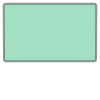

In [5]:
bounding_box = gdf.unary_union.convex_hull.buffer(0.01)
bounding_box

## Fetch and filter Sentinel 2 granules

Specify a STAC API. Sentinel 2 and Landsat collections are stored at AWS.

In [6]:
api = Client.open('https://earth-search.aws.element84.com/v0')
print('This API provides access to the following STAC catalogs')
for link in api.get_links('child'):
    print(link)

This API provides access to the following STAC catalogs
<Link rel=child target=https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a>
<Link rel=child target=https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l1c>
<Link rel=child target=https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs>
<Link rel=child target=https://earth-search.aws.element84.com/v0/collections/landsat-8-l1-c1>


Search for granules that intersect fully or partially with the bounding box. The variable `collection` is a collection of just the meta data. It would be too much to download the full data of all matching granules. We'll filter the list first and then download only one of the granules.

In [7]:
search = api.search(
    # max_items=10,
    collections=('sentinel-s2-l2a-cogs',),
    query={
        'eo:cloud_cover': {'lt': 0.1},  # filter by cloud coverage
        'sentinel:valid_cloud_cover': {'eq': True},
    },
    intersects=bounding_box,
)
collection = search.get_all_items()
print(f'Number matched: {search.matched()}')

Number matched: 48


In [8]:
# We can save and/or load the search results for future runs.
#collection.save_object('collection.json')
#collection = ItemCollection.from_file('collection.json')

Narrow the list of granules down to the minimal number that touch the bounding box.

Target area: 0.12990086791395938
Current area: 0.12990086791395936
Number of granules: 1


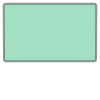

In [9]:
print(f'Target area: {bounding_box.area}')
# Sum of bounding boxes of all granules currently being considered.
# This is an intersection with the main bounding box.
all_boxes = Polygon()
# List of granules (metadata) being considered in the end
collection_filtered = []
for i_granule, granule in enumerate(collection):
    # Crop the bounding box of this granule with the main bounding box
    bounding_box_cur = Polygon(granule.geometry['coordinates'][0]).intersection(bounding_box)
    # If adding this box to the list of previously accepted box increases
    # the total area by a certain margin then accept this box.
    all_boxes_cur = shapely.ops.unary_union([all_boxes, bounding_box_cur])
    if abs(all_boxes_cur.area - all_boxes.area) > 0.02:
        all_boxes = all_boxes_cur
        collection_filtered.append(granule)
print(f'Current area: {all_boxes.area}')
print(f'Number of granules: {len(collection_filtered)}')
all_boxes

Have a quick look at the accepted granule(s)

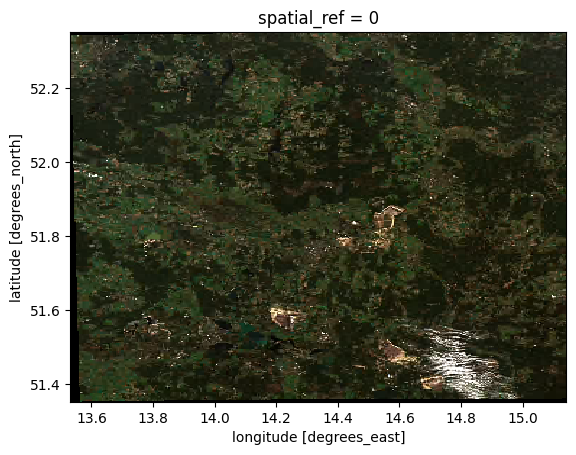

In [10]:
overview = rioxarray.open_rasterio(collection_filtered[0].assets['overview'].get_absolute_href())
overview = overview.rio.reproject('EPSG:4326', shape=(overview.shape[1], overview.shape[2]))
overview.plot.imshow()

Extract the high resolution albedo map of a selected wavelength (B07 is 783 nm)

In [11]:
data = rioxarray.open_rasterio(collection_filtered[0].assets['B07'].get_absolute_href())

Note that the albedo values need to be divided by 10,000.

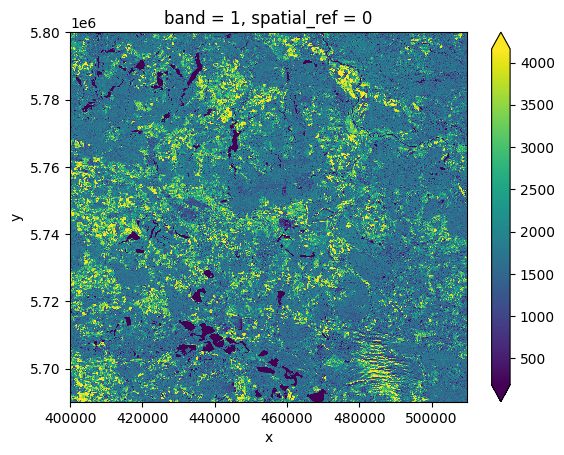

In [12]:
data[::4, ::4].plot(robust=True)  # Every 4th element to reduce plotting time

### Convolve with the response function

In [13]:
from scipy.signal import fftconvolve
kernel_extent = 401  # pixels
x, y = np.meshgrid(np.linspace(-1, 1, kernel_extent),
                   np.linspace(-1, 1, kernel_extent))
diff = np.sqrt(x * x + y * y)
sigma = 0.09
kernel = np.exp(-((diff)**2 / (2.0 * sigma**2)))
kernel /= kernel.sum()
image_conv = fftconvolve(data.values[0], kernel)
data.data = [image_conv[kernel_extent // 2: -(kernel_extent // 2),
                        kernel_extent // 2: -(kernel_extent // 2)]]

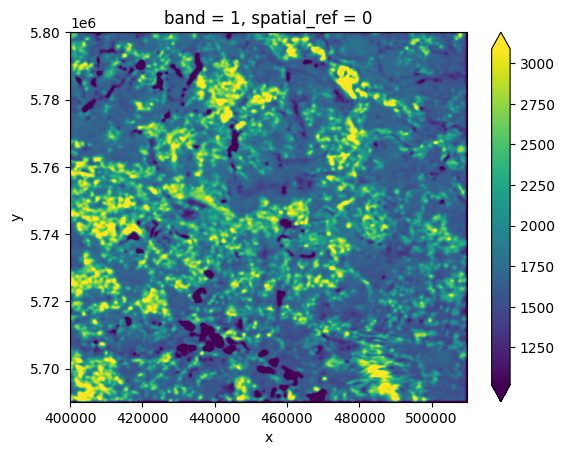

In [14]:
data[::4, ::4].plot(robust=True)

### Change coordinate system to WGS84

In [15]:
data_resampled = data.rio.reproject('EPSG:4326')

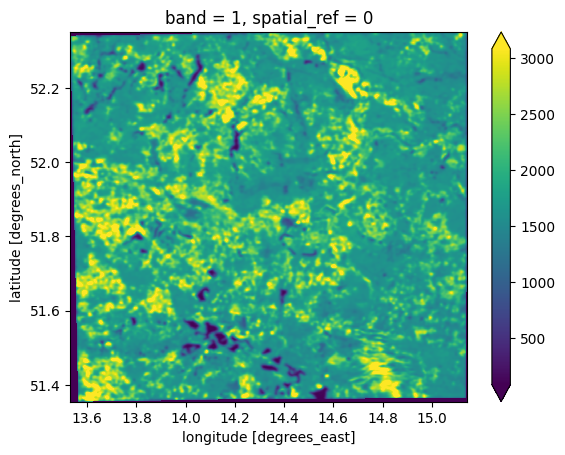

In [16]:
data_resampled[::4, ::4].plot(robust=True)

## Extract data on target grid

In [26]:
interp = RegularGridInterpolator((data_resampled.y, data_resampled.x), data_resampled.values[0], method='cubic')

The 2D interpolator only works with 1D lat/lon grids.

In [27]:
lat_flat = lat.flatten()
lon_flat = lon.flatten()

In [28]:
target_points = np.zeros((len(lat_flat), 2))
for i_point in range(len(target_points)):
    target_points[i_point] = [lat_flat[i_point], lon_flat[i_point]]

In [29]:
albedos = np.reshape(interp(target_points), lat.shape)

Divide by 10,000 to get the true albedo values

In [30]:
albedos = albedos / 1e4

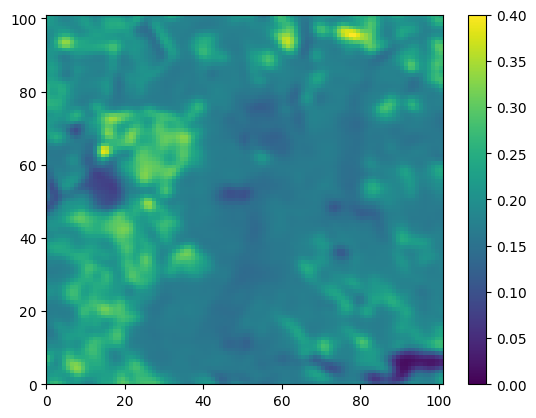

In [31]:
fig, ax = plt.subplots()
psm = ax.pcolormesh(
    albedos,
    vmin=0,
    vmax=0.4,
    rasterized=True)
cb = fig.colorbar(psm, ax=ax)

Final: `albedos` are the albedo values on the input grid.